<a href="https://colab.research.google.com/github/Onwi/FCG/blob/main/Under_e_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Baseado no Tutorial: https://thedatafrog.com/en/articles/overfitting-illustrated/

Imports e configurações iniciais:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
np.random.seed(0xdeadbeef)
# blah

## Dataset Fictício

Classificação binária com duas entradas: x1 e x2.

Amostras da classe 0, são geradas com uma Gaussiana 2D centrada em (0,0) com "desvio padrão" 1.
Amostras da classe 1, são geradas com a Gaussian centrada em (1,1).

In [ ]:
def make_sample(nexamples, means=([0.,0.],[1.,1.]), sigma=1.):
    normal = np.random.multivariate_normal
    # squared width:
    s2 = sigma**2.
    # below, we provide the coordinates of the mean as
    # a first argument, and then the covariance matrix
    # which describes the width of the Gaussian along the
    # two directions.
    # we generate nexamples examples for each category
    sgx0 = normal(means[0], [[s2, 0.], [0.,s2]], nexamples)
    sgx1 = normal(means[1], [[s2, 0.], [0.,s2]], nexamples)
    # setting the labels for each category
    sgy0 = np.zeros((nexamples,))
    sgy1 = np.ones((nexamples,))
    sgx = np.concatenate([sgx0,sgx1])
    sgy = np.concatenate([sgy0,sgy1])
    return sgx, sgy

Conjunto de treino inicial pequeno (sgx, sgy) com 30 amostras, pra mostrar que poucos dados favorecem overfitting.

O conjunto de teste (tgx, tgy) tem 200 amostras.

In [ ]:
sgx, sgy = make_sample(30)
tgx, tgy = make_sample(200)

Text(0, 0.5, 'x2')

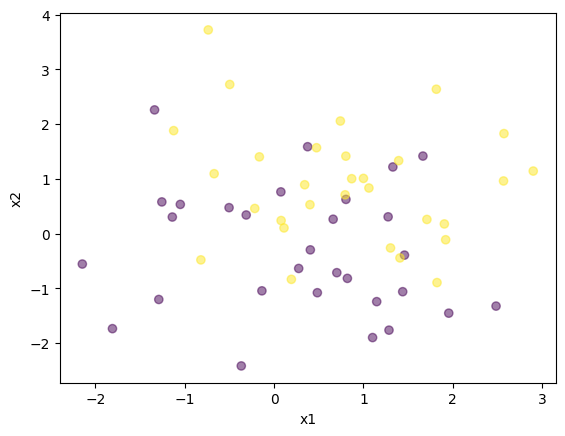

In [ ]:
# plot do dataset pequeno, as cores são de acordo com a classe
plt.scatter(sgx[:,0], sgx[:,1], alpha=0.5, c=sgy)
plt.xlabel('x1')
plt.ylabel('x2')

Com tão poucos exemplos, nem parece que eles vem de distribuições gaussianas e além disso não parece fácil separá-los.

## Overfitting

Vamos tentar classificar os dados com uma rede neural "complexa". Ela é construida na celula abaixo, de acordo com 2 ferramentas (scikit-learn e keras) com as características (pode ser customizado):

3 camadas ocultas de 50 neurônios cada. Ativação ReLU. Otimizador Adam (uma variação sofisticada da descida de gradiente).

Embora as duas redes tenham a mesma arquitetura e configurações o mais próximo possível, os resultados são diferentes...

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf

def get_scikit_mlp(data_x, data_y):
  mlp = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=10000, random_state=1)
  mlp.fit(data_x, data_y)
  return mlp

def get_keras_mlp(data_x, data_y):
  mlp = tf.keras.models.Sequential([
      tf.keras.layers.Dense(50, activation='relu', input_dim=2),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, mode='max', start_from_epoch=200, baseline=0.9)
  mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  mlp.fit(data_x, data_y, epochs=1000, verbose=0, callbacks=[callback])
  return mlp

Abaixo há duas funcoes para plotar os resultados. A diferença é em como se pega as predições no scikit e no Keras.

As funções plotam os exemplos e uma probabilidade de cada ponto no espaço ser da classe 0 (branco) ou 1 (preto). Não se preocupe com esse código, apenas que ele recebe a rede treinada e os dados para mostrar.

In [ ]:
def plot_result_scikit(model, data_x, data_y, linrange=(-5,5,101)):
    xmin, xmax, npoints = linrange
    gridx1, gridx2 = np.meshgrid(np.linspace(xmin,xmax,npoints), np.linspace(xmin,xmax,npoints))
    grid = np.c_[gridx1.flatten(), gridx2.flatten()]

    probs = model.predict_proba(grid)

    accuracy = accuracy_score(data_y, model.predict(data_x))
    print(f"Accuracy: {accuracy:.5f}")

    #print(probs)
    plt.pcolor(gridx1, gridx2, probs[:,1].reshape(npoints,npoints), cmap='binary')
    plt.colorbar()
    plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap='plasma', alpha=0.5, marker='.')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

def plot_result_keras(model, data_x, data_y, linrange=(-5,5,101)):
    xmin, xmax, npoints = linrange
    gridx1, gridx2 = np.meshgrid(np.linspace(xmin,xmax,npoints), np.linspace(xmin,xmax,npoints))
    grid = np.c_[gridx1.flatten(), gridx2.flatten()]

    probs = model.predict(grid)     # predictions for points in grid space
    complement_probs = 1 - probs
    probs = np.concatenate((probs, complement_probs), axis=1)

    predictions = model.predict(data_x)  # predictions for samples
    classes = np.where(predictions > 0.5, 1,0)   # if pred > 0.5: class = 1
    accuracy = accuracy_score(data_y, classes)
    print(f"Accuracy: {accuracy:.5f}")          # TODO usar evaluate do keras, bem + simples

    #print(probs)
    plt.pcolor(gridx1, gridx2, probs[:,1].reshape(npoints,npoints), cmap='binary')
    plt.colorbar()
    plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap='plasma', alpha=0.5, marker='.')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

Accuracy: 1.00000


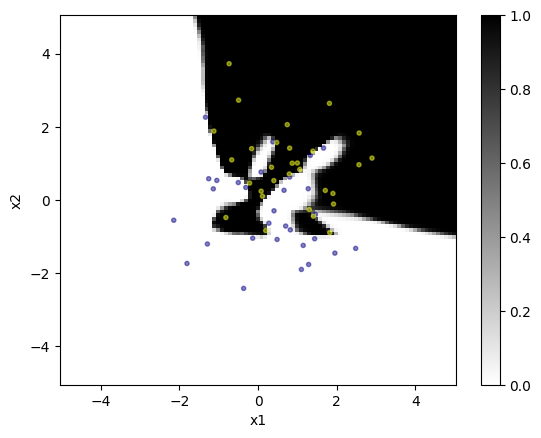

In [ ]:
scikit_model = get_scikit_mlp(sgx, sgy)     # alternar pelas abaixo se usar keras
plot_result_scikit(scikit_model, sgx,sgy)

#keras_model = get_keras_mlp(sgx, sgy)
#plot_result_keras(keras_model, sgx,sgy)

Os pontos estão bem ajustados pela superfície de decisão. Porém, ela está longe de capturar a distribuição dos pontos (as gaussianas).


Vamos plotar para os dados de teste

Accuracy: 0.63750


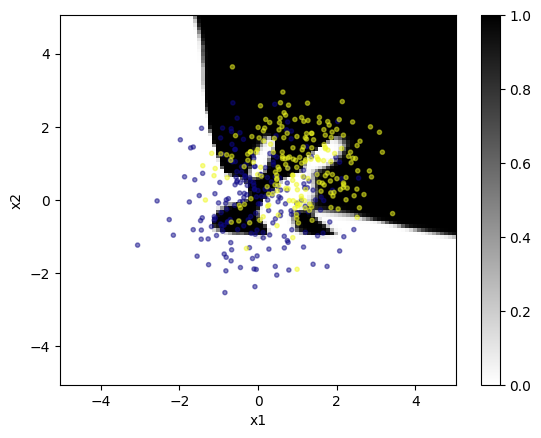

In [ ]:
plot_result_scikit(scikit_model, tgx,tgy)
#plot_result_keras(keras_model, tgx,tgy)

Um monte de exemplos foram mal classificados. A rede foi muito bem no treino, e mal no teste.

**Isso é overfitting.**

## Testando uma rede menor

Modifique o código abaixo para retornar uma rede de apenas uma camada oculta com 5 neurônios. A rede será treinada na amostra pequena e avaliada na amostra de teste.

In [ ]:
def get_smaller_scikit_mlp(data_x, data_y):
  # esta aqui já esta com o tamanho apropriado
  mlp = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=10000, random_state=1)
  mlp.fit(data_x, data_y)
  return mlp

def get_smaller_keras_mlp(data_x, data_y):
  # ajuste esta para ter somente uma camada oculta de 5 neuronios
  mlp = tf.keras.models.Sequential([
      tf.keras.layers.Dense(50, activation='relu', input_dim=2),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, mode='max', start_from_epoch=200, baseline=0.9)
  mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  mlp.fit(data_x, data_y, epochs=1000, verbose=0, callbacks=[callback])
  return mlp

Accuracy: 0.72000


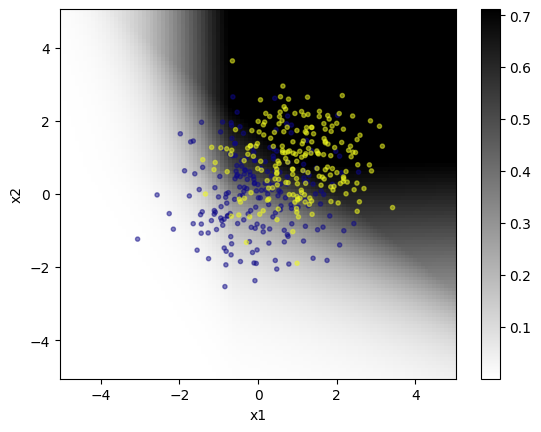

In [ ]:
scikit_model = get_smaller_scikit_mlp(sgx, sgy)     # alternar pelas abaixo se usar keras
plot_result_scikit(scikit_model, tgx, tgy)

#keras_model = get_smaller_keras_mlp(sgx, sgy)
#plot_result_keras(keras_model, tgx, tgy)

Agora, a rede não tem parâmetros suficientes pra seguir as aleatoriedades do conjunto de treinamento, e tenta encontrar um padrão geral.

Exercício: treinar as redes complexas em um conjunto de dados maior (preencha na celula abaixo). Qual o comportamento da rede com relação ao overfitting?

In [ ]:
# use o make_sample para gerar 10000 amostras
# use a rede com 3 camadas ocultas de 50 neuronios cada
# plote os resultados do modelo para os dados de teste (tgx e tgy)


## Redes complexas para dados complexos

Vamos construir um dataset complexo com 8 "montanhas" Gaussianas de dados, cada uma centrada em uma coordenada do espaço.

Cada chamada a make_sample cria 2 montanhas, uma pra cada classe, de acordo com as coordenadas especificadas.

In [ ]:
sgxa, sgya = make_sample(100, ([0.,0],[1.,1.]), 0.3)
sgxb, sgyb = make_sample(100, ([3.,3],[4.,4.]), 0.3)
sgxc, sgyc = make_sample(100, ([5.,5.],[-2.,-2.]), 0.6)
sgxd, sgyd = make_sample(100, ([-1,3.],[3.,-1.]), 0.3)

data_x = np.concatenate([sgxa,sgxb,sgxc,sgxd])
data_y = np.concatenate([sgya,sgyb,sgyc,sgyd])

Text(0, 0.5, 'x2')

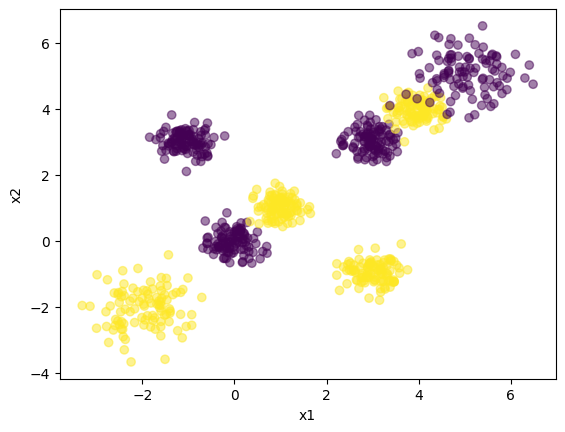

In [ ]:
#plt.scatter(data_x[:,0], data_x[:,1], alpha=0.5, c=sgy)
plt.scatter(data_x[:,0], data_x[:,1], alpha=0.5, c=data_y)
plt.xlabel('x1')
plt.ylabel('x2')

Uma rede pequena poderá classificar esses dados corretamente? Preencha abaixo o código com uma rede muito simples (1 camada oculta de 3 neuronios). Use a do scikit que dá pra especificar em 1 linha.

Accuracy: 0.73875


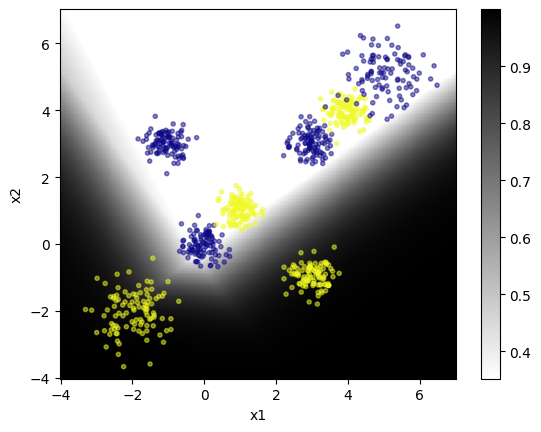

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(3,), activation='relu', max_iter=10000)
mlp.fit(data_x, data_y)
plot_result_scikit(mlp, data_x, data_y,linrange=(-4,7,201))

A rede até faz um trabalho decente, mas não tem parâmetros suficientes para se ajustar aos dados.

**Isso é underfitting.**

A seguir, especifique um MLPClassifier com 1 camada oculta de 5 neuronios:

In [ ]:
mlp = MLPClassifier(...)
mlp.fit(...)
plot_result_scikit(mlp, data_x, data_y,linrange=(-4,7,201))

O desempenho melhorou, mas vamos dar "poder preditivo" suficiente à rede, colocando 3 camadas ocultas de 50 neurônios cada:

In [ ]:
mlp = MLPClassifier(...)
mlp.fit(...)
plot_result_scikit(mlp, data_x, data_y,linrange=(-4,7,201))

Exercício opcional:
Refazer as execuções usando a rede do Keras. O comportamento geral (over e underfitting) também é observado? Os resultados são idênticos aos do scikit?